In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load the dataset
file_path = 'attribution_data.csv'  # Update this to your actual file path
data = pd.read_csv(file_path)

# Convert 'time' to datetime format
data['time'] = pd.to_datetime(data['time'])

## First-Touch Attribution Model

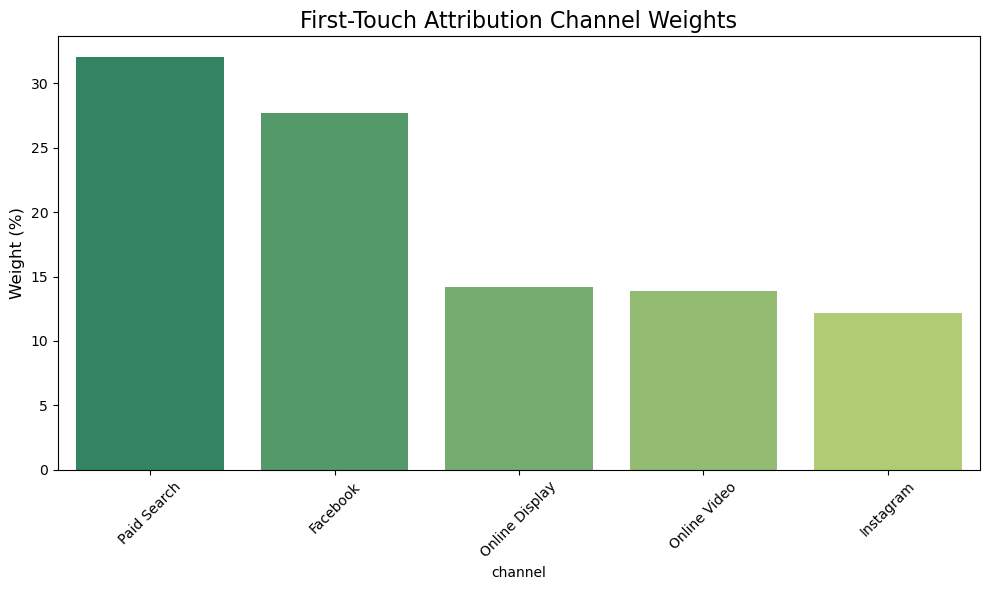

In [2]:
# First-Touch Attribution Model
def first_touch_attribution(df, user_id, channel_col, conv_col):
    """First-Touch Attribution Model"""
    first_touch = df.groupby(user_id).first()
    first_touch_results = first_touch.groupby(channel_col)[conv_col].sum().reset_index()
    first_touch_results.columns = [channel_col, 'Conversions']
    
    # Calculate percentage
    first_touch_results['Weight (%)'] = (first_touch_results['Conversions'] / first_touch_results['Conversions'].sum()) * 100
    return first_touch_results.sort_values(by='Weight (%)', ascending=False)

# Apply First-Touch Model and plot
first_touch_results = first_touch_attribution(data, 'cookie', 'channel', 'conversion')

# Plotting First-Touch Attribution
plt.figure(figsize=(10, 6))
sns.set_palette('summer')  # Set color palette
sns.barplot(x=first_touch_results['channel'], y=first_touch_results['Weight (%)'])

plt.title("First-Touch Attribution Channel Weights", fontsize=16)
plt.ylabel("Weight (%)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Last-Touch Attribution Model

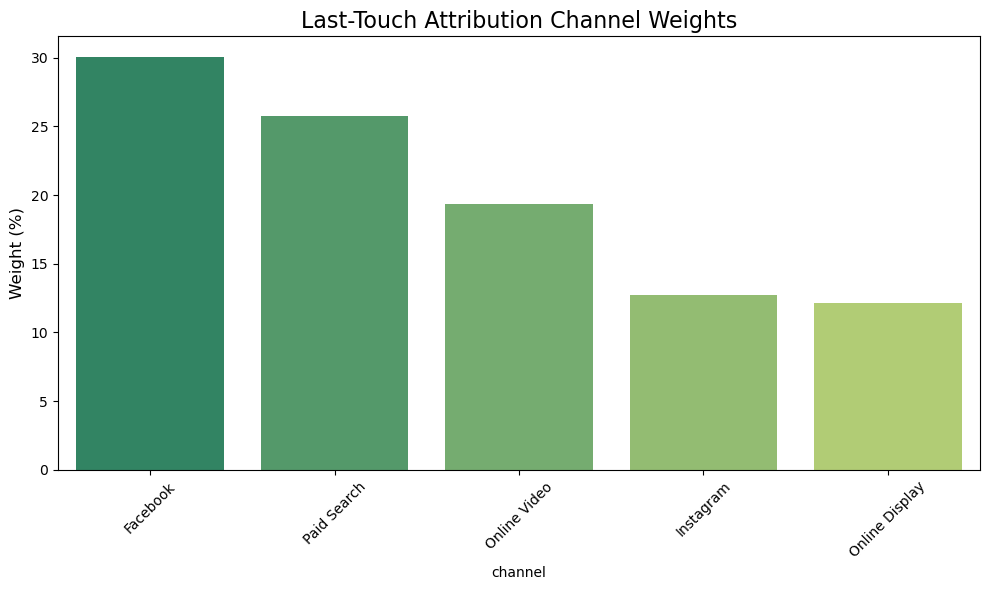

In [3]:
# Last-Touch Attribution Model
def last_touch_attribution(df, user_id, channel_col, conv_col):
    """Last-Touch Attribution Model"""
    last_touch = df.groupby(user_id).last()
    last_touch_results = last_touch.groupby(channel_col)[conv_col].sum().reset_index()
    last_touch_results.columns = [channel_col, 'Conversions']
    
    # Calculate percentage
    last_touch_results['Weight (%)'] = (last_touch_results['Conversions'] / last_touch_results['Conversions'].sum()) * 100
    return last_touch_results.sort_values(by='Weight (%)', ascending=False)

# Apply Last-Touch Model and plot
last_touch_results = last_touch_attribution(data, 'cookie', 'channel', 'conversion')

# Plotting Last-Touch Attribution
plt.figure(figsize=(10, 6))
sns.set_palette('summer')  # Set color palette
sns.barplot(x=last_touch_results['channel'], y=last_touch_results['Weight (%)'])

plt.title("Last-Touch Attribution Channel Weights", fontsize=16)
plt.ylabel("Weight (%)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Linear Attribution Model

/var/folders/lt/t4bhjb2s737f5f8kmxcrx7k00000gn/T/ipykernel_2553/2245473907.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_converted['interaction_count'] = df_converted[user_id].map(user_interaction_count)
/var/folders/lt/t4bhjb2s737f5f8kmxcrx7k00000gn/T/ipykernel_2553/2245473907.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_converted['interaction_weight'] = 100 / df_converted['interaction_count']


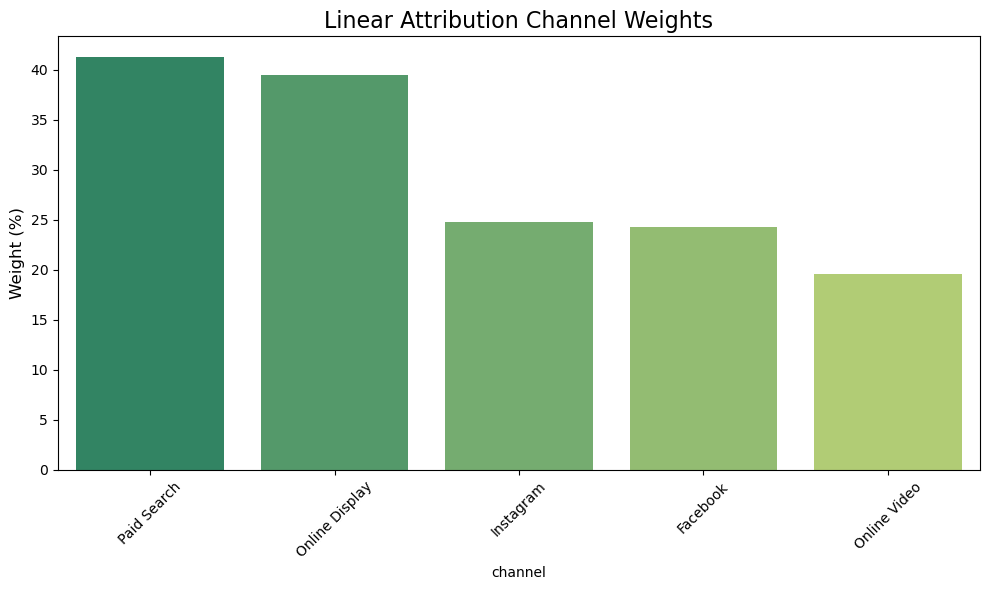

In [4]:
# Linear Attribution Model
def linear_attribution(df, user_id, channel_col, conv_col):
    """Linear Attribution Model"""
    converted_users = df[df[conv_col] == 1]
    user_ids = list(converted_users[user_id])
    df['is_converted_user'] = df[user_id].isin(user_ids)
    df_converted = df[df['is_converted_user']]
    
    user_interaction_count = Counter(df_converted[user_id])
    df_converted['interaction_count'] = df_converted[user_id].map(user_interaction_count)
    
    df_converted['interaction_weight'] = 100 / df_converted['interaction_count']
    channel_weights = df_converted.groupby(channel_col)['interaction_weight'].mean().reset_index()
    
    channel_weights.columns = [channel_col, 'Weight (%)']
    return channel_weights.sort_values(by='Weight (%)', ascending=False)

# Apply Linear Attribution Model and plot
linear_attribution_results = linear_attribution(data, 'cookie', 'channel', 'conversion')

# Plotting Linear Attribution
plt.figure(figsize=(10, 6))
sns.set_palette('summer')  # Set color palette
sns.barplot(x=linear_attribution_results['channel'], y=linear_attribution_results['Weight (%)'])

plt.title("Linear Attribution Channel Weights", fontsize=16)
plt.ylabel("Weight (%)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## U-Shaped Attribution Model

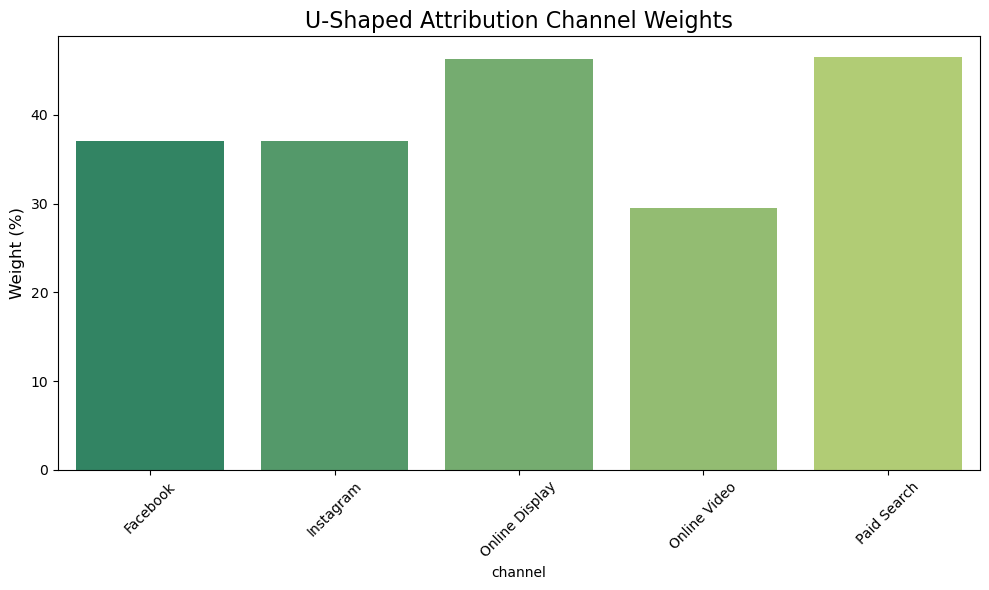

In [5]:
# U-Shaped Attribution Model
def u_shaped_attribution(df, user_id, channel_col, conv_col):
    """U-Shaped Attribution Model"""
    u_shaped_attributions = []
    
    def calculate_u_shaped_weights(group):
        if len(group) == 1:
            return pd.DataFrame({'channel': [group.iloc[0][channel_col]], 'Weight (%)': [100]})
        
        first_touch_value = 0.4 * 100
        last_touch_value = 0.4 * 100
        if len(group) > 2:
            middle_weight = 0.2 * 100 / (len(group) - 2)
            group['Weight (%)'] = middle_weight
            group.iloc[0, group.columns.get_loc('Weight (%)')] = first_touch_value
            group.iloc[-1, group.columns.get_loc('Weight (%)')] = last_touch_value
        elif len(group) == 2:
            group.iloc[0, group.columns.get_loc('Weight (%)')] = first_touch_value
            group.iloc[-1, group.columns.get_loc('Weight (%)')] = last_touch_value
        
        return group[[channel_col, 'Weight (%)']]
    
    for name, group in df.groupby(user_id):
        group = group.copy()
        group['Weight (%)'] = 0
        result = calculate_u_shaped_weights(group)
        u_shaped_attributions.append(result)
    
    u_shaped_results = pd.concat(u_shaped_attributions)
    return u_shaped_results.groupby(channel_col)['Weight (%)'].mean().reset_index()

# Apply U-Shaped Model and plot
u_shaped_results = u_shaped_attribution(data, 'cookie', 'channel', 'conversion')

# Plotting U-Shaped Attribution
plt.figure(figsize=(10, 6))
sns.set_palette('summer')  # Set color palette
sns.barplot(x=u_shaped_results['channel'], y=u_shaped_results['Weight (%)'])

plt.title("U-Shaped Attribution Channel Weights", fontsize=16)
plt.ylabel("Weight (%)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()